# SWAN BOUNDNEST1

This notebooks shows examples of how to prescribe BOUNDNEST1 spectral boundaries
using rompy boundary data objects.

Boundary of type `BOUNDNEST1` can be specified from existing spectral data using
the `rompy_swan.boundary.Boundnest1` object. Spectra are interpolated or nearest-selected
from a source spectra dataset along the model grid and saved as a single SWAN SPEC2D
ASCII file.

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from tempfile import mkdtemp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import wavespectra

from rompy.core.source import SourceFile
from rompy.core.time import TimeRange
from rompy_swan.grid import SwanGrid
from rompy_swan.boundary import Boundnest1

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def plot_boundary_side(dset, bnd, grid, time):
    """Plot side boundary stats.

    This function plots a snapshot of wave statistics from the source spectra dataset
    and the boundary wave stats generated for a grid from those spectra points.

    Parameters
    ----------
    dset: xr.Dataset
        Source spectra dataset used to define boundary from.
    bnd: xr.Dataset
        Boundary dataset read from the SWAN ASCII file.
    grid: SwanGrid
        Grid object defining the SWAN domain.
    time: Datatime | str
        Time to plot.

    """
    # xb, yb = bnd._boundary_points(grid)
    xb = grid.x[:, 0]
    yb = grid.y[:, 0]

    fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 3.5))

    # Hs
    ax = axs[0]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.hs(), cmap="turbo", vmin=2.0, vmax=3.5)
    plt.colorbar(p, label="Hs (m)")
    ax.scatter(bnd.lon, bnd.lat, s=40, c=bnd.sel(time=time).spec.hs(), marker="s", edgecolor="k", linewidth=0.5, cmap="turbo", vmin=2.0, vmax=3.5)

    # Tp
    ax = axs[1]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.tp(), cmap="viridis", vmin=13.8, vmax=14.5)
    plt.colorbar(p, label="Tp (s)")
    ax.scatter(bnd.lon, bnd.lat, s=40, c=bnd.sel(time=time).spec.tp(), marker="s", edgecolor="k", linewidth=0.5, cmap="viridis", vmin=13.8, vmax=14.5)

    # Dpm
    ax = axs[2]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.dpm(), cmap="hsv", vmin=220, vmax=225)
    plt.colorbar(p, label="Dpm (deg)")
    ax.scatter(bnd.lon, bnd.lat, s=40, c=bnd.sel(time=time).spec.dpm(), marker="s", edgecolor="k", linewidth=0.5, cmap="hsv", vmin=220, vmax=225)

    for ax in axs:
        grid.plot(ax=ax, fscale=5)
        ax.set_extent([110.5, 115.5, -29.5, -23.5])
        ax.set_title(time)
        ax.coastlines()

In [3]:
datadir = Path("../../../../rompy-swan/tests/data")
modeldir = Path("model")
modeldir.mkdir(exist_ok=True)

### Define rompy objects

Create instances of source, time and grid objects to use with the boundary classes

In [4]:
# source defines the dataset to be used to create the model boundary

source = SourceFile(
    uri=datadir / "aus-20230101.nc",
    kwargs=dict(engine="netcdf4"),
)
dset = source.open()
dset

<xarray.Dataset> Size: 1MB
Dimensions:  (site: 412, time: 5, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 40B 2023-01-01 ... 2023-01-02
  * site     (site) int64 3kB 0 4 8 12 16 20 ... 1624 1628 1632 1636 1640 1644
  * freq     (freq) float32 44B 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float32 32B 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    lon      (site) float32 2kB ...
    lat      (site) float32 2kB ...
    efth     (time, site, freq, dir) float64 1MB ...
    dpt      (time, site) float32 8kB ...
    wspd     (time, site) float32 8kB ...
    wdir     (time, site) float32 8kB ...
Attributes: (12/16)
    product_name:           ww3.all_spec.nc
    area:                   Global 0.5 x 0.5 degree
    data_type:              OCO spectra 2D
    format_version:         1.1
    southernmost_latitude:  n/a
    northernmost_latitude:  n/a
    ...                     ...
    minimum_altitude:       n/a
    maximum_altitude:       n/a
    altitude_resolution:    n/a
    start_date:             2023-01-01 00:00:00
    stop_date:              2023-02-01 00:00:00
    field_type:             3-hourly

In [5]:
# times prescribe the times over which the model will run

times = TimeRange(start="2023-01-01T00", end="2023-01-02T00", interval="6h")
print(times)


	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 day
	Interval: 6:00:00
	Include End: True



In [6]:
# grid defines the model grid

grid = SwanGrid(x0=112, y0=-29, dx=0.5, dy=0.5, nx=8, ny=9, rot=20)
print(grid)

SwanGrid: REG, 8x9


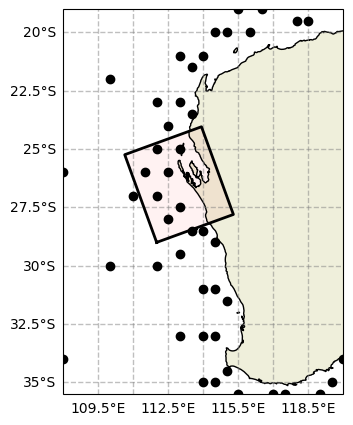

In [7]:
# Plot model grid and boundary points in the source spectra

fig, ax = grid.plot(fscale=5)
ax.plot(dset.lon, dset.lat, "ok")
ax.set_extent([108, 120, -35.5, -19])

### Boundnest1 with IDW interpolation at all boundary points

Create `BOUNDNEST1` type SWAN boundary by interpolating from the source spectra
dataset along the model domain using the *Inverse Distance Weighting* (`idw`) sel
method from wavespectra. Boundary data are defined at all points along the grid
boundary given the `spacing` parameter isn't prescribed

<div class="alert alert-block alert-warning">
⚠️ When using IDW, missing values are returned for locations that do not have three or
  more sites withing tolerance in the source dataset. This is okay for land locations
  but will be problematic for locations expecting an open boundary. Use a larger
  tolerance when encountering this problem.
</div>

In [8]:
workspace = Path(mkdtemp(dir="model"))

bnd = Boundnest1(
    id="wa",
    source=source,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 2.0},
    rectangle="closed",
)

filename, cmd = bnd.get(destdir=workspace, grid=grid, time=times)

display(cmd)
os.system(f"head -n 80 {filename}");

"BOUNDNEST1 NEST 'wa.bnd' CLOSED"

SWAN   1                                Swan standard spectral file
$   Created by wavespectra
$   
TIME                                    time-dependent data
     1                                  time coding option
LONLAT                                  locations in spherical coordinates
    31                                  number of locations
  112.000000  -29.000000
  112.469846  -28.828990
  112.939693  -28.657980
  113.409539  -28.486970
  113.879385  -28.315960
  114.349232  -28.144950
  114.819078  -27.973940
  115.288924  -27.802929
  115.117914  -27.333083
  114.946904  -26.863237
  114.775894  -26.393391
  114.604884  -25.923544
  114.433874  -25.453698
  114.262864  -24.983852
  114.091854  -24.514005
  113.920844  -24.044159
  113.450997  -24.215169
  112.981151  -24.386179
  112.511305  -24.557189
  112.041458  -24.728199
  111.571612  -24.899209
  111.101766  -25.070219
  110.631919  -25.241230
  110.802929  -25.711076
  110.973940  -26.180922
  111.144950  -26.650

<xarray.Dataset> Size: 110kB
Dimensions:  (time: 5, site: 31, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 40B 2023-01-01 ... 2023-01-02
  * site     (site) int64 248B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * freq     (freq) float64 88B 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 64B 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, site, freq, dir) float64 109kB 0.0 0.0 0.0 ... 4.87e-05 0.0
    lat      (site) float64 248B -29.0 -28.83 -28.66 ... -28.06 -28.53 -29.0
    lon      (site) float64 248B 112.0 112.5 112.9 113.4 ... 111.7 111.8 112.0

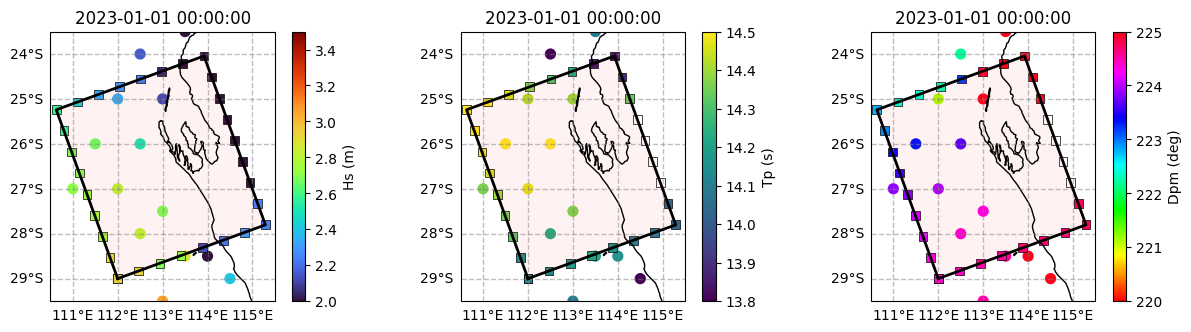

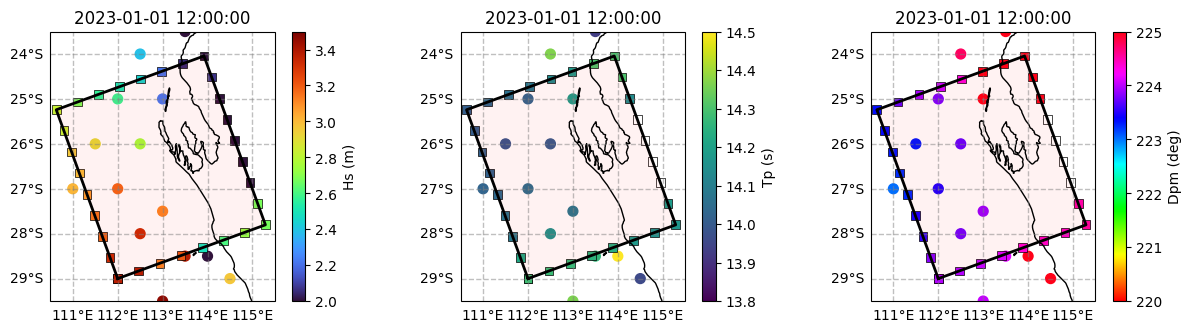

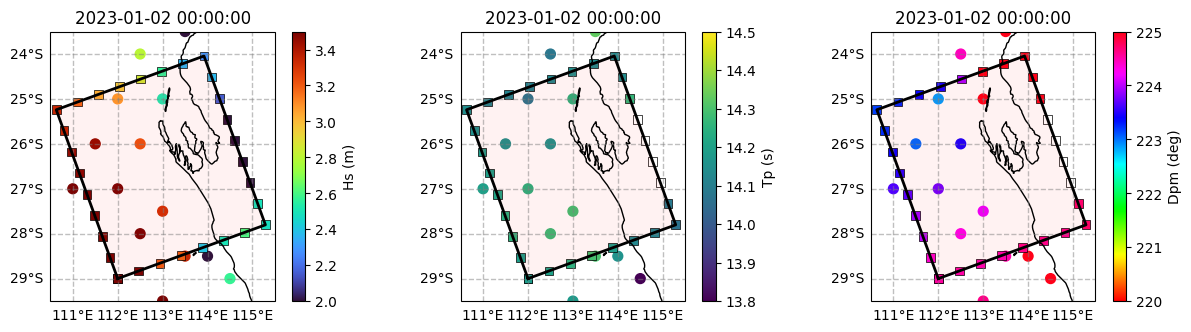

In [9]:
# Load the boundary created as a dataset
ds = wavespectra.read_swan(filename, as_site=True)
display(ds)

# Plot boundary stats calculated from ds
for time in ds.time.to_index()[::2]:
    plot_boundary_side(dset, ds, grid, time)

### Boundnest1 with nearest selection at all boundary points

Create `BOUNDNEST1` type SWAN boundary by nearest-selecting from the source spectra
dataset along the model domain using the *Nearest Neighbour* (`nearest`) sel
method from wavespectra. Boundary data are defined at all points along the grid
boundary given the `spacing` parameter isn't prescribed

<div class="alert alert-block alert-warning">
⚠️ When using nearest, exceptions are raised for locations that do not have at least one
  site placed withing tolerance in the source dataset. Use a larger tolerance when
  encountering this problem.
</div>

In [10]:
workspace = Path(mkdtemp(dir="model"))

bnd = Boundnest1(
    id="wa",
    source=source,
    sel_method="nearest",
    sel_method_kwargs={"tolerance": 2.5},
    rectangle="closed",
)

filename, cmd = bnd.get(destdir=workspace, grid=grid, time=times)

display(cmd)
os.system(f"head -n 80 {filename}");

"BOUNDNEST1 NEST 'wa.bnd' CLOSED"

SWAN   1                                Swan standard spectral file
$   Created by wavespectra
$   
TIME                                    time-dependent data
     1                                  time coding option
LONLAT                                  locations in spherical coordinates
    31                                  number of locations
  112.000000  -29.000000
  112.469846  -28.828990
  112.939693  -28.657980
  113.409539  -28.486970
  113.879385  -28.315960
  114.349232  -28.144950
  114.819078  -27.973940
  115.288924  -27.802929
  115.117914  -27.333083
  114.946904  -26.863237
  114.775894  -26.393391
  114.604884  -25.923544
  114.433874  -25.453698
  114.262864  -24.983852
  114.091854  -24.514005
  113.920844  -24.044159
  113.450997  -24.215169
  112.981151  -24.386179
  112.511305  -24.557189
  112.041458  -24.728199
  111.571612  -24.899209
  111.101766  -25.070219
  110.631919  -25.241230
  110.802929  -25.711076
  110.973940  -26.180922
  111.144950  -26.650

<xarray.Dataset> Size: 110kB
Dimensions:  (time: 5, site: 31, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 40B 2023-01-01 ... 2023-01-02
  * site     (site) int64 248B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * freq     (freq) float64 88B 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 64B 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, site, freq, dir) float64 109kB 0.0 0.0 0.0 ... 0.0 0.0
    lat      (site) float64 248B -29.0 -28.83 -28.66 ... -28.06 -28.53 -29.0
    lon      (site) float64 248B 112.0 112.5 112.9 113.4 ... 111.7 111.8 112.0

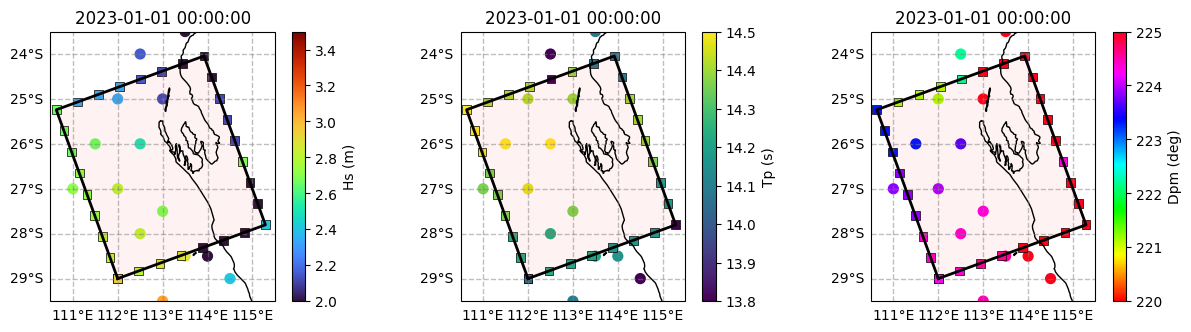

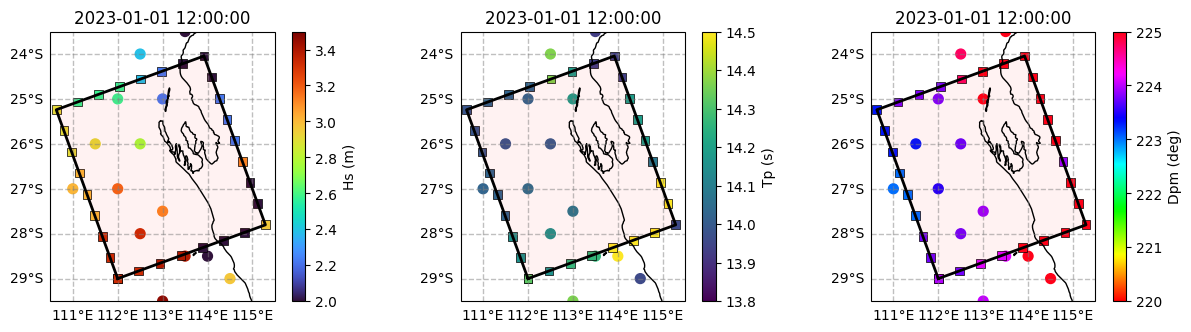

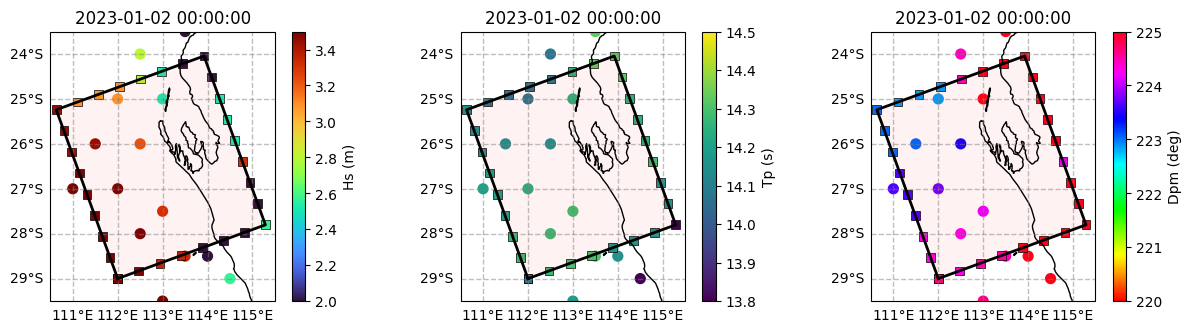

In [11]:
# Load the boundary created as a dataset
ds = wavespectra.read_swan(filename, as_site=True)
display(ds)

# Plot boundary stats calculated from ds
for time in ds.time.to_index()[::2]:
    plot_boundary_side(dset, ds, grid, time)

### Boundnest1 with spacing defined from the parent dataset

Create `BOUNDNEST1` type SWAN boundary by interpolating from the source spectra
dataset along the model domain at locations along the grid boundary defined acording
to the minimum spacing between points in the source dataset.

<div class="alert alert-block alert-info">
⚠️ When using any custom spacing, it is possible there won't be boundary points defined
  at some of the grid vertices if the grid sides are not divisible by the spacing.
</div>

In [12]:
workspace = Path(mkdtemp(dir="model"))

bnd = Boundnest1(
    id="wa",
    source=source,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 2.0},
    rectangle="closed",
    spacing="parent",
)

filename, cmd = bnd.get(destdir=workspace, grid=grid, time=times)

display(cmd)
os.system(f"head -n 80 {filename}");

"BOUNDNEST1 NEST 'wa.bnd' CLOSED"

SWAN   1                                Swan standard spectral file
$   Created by wavespectra
$   
TIME                                    time-dependent data
     1                                  time coding option
LONLAT                                  locations in spherical coordinates
    22                                  number of locations
  112.000000  -29.000000
  112.664463  -28.758155
  113.328926  -28.516310
  113.993389  -28.274466
  114.657852  -28.032621
  115.276771  -27.769539
  115.034926  -27.105076
  114.793081  -26.440612
  114.551237  -25.776150
  114.309392  -25.111687
  114.067547  -24.447223
  113.659445  -24.139300
  112.994982  -24.381145
  112.330519  -24.622990
  111.666056  -24.864835
  111.001593  -25.106679
  110.739214  -25.536019
  110.981059  -26.200482
  111.222903  -26.864945
  111.464748  -27.529408
  111.706593  -28.193871
  111.948438  -28.858334
AFREQ                                   absolute frequencies in Hz
    11                       

<xarray.Dataset> Size: 78kB
Dimensions:  (time: 5, site: 22, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 40B 2023-01-01 ... 2023-01-02
  * site     (site) int64 176B 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22
  * freq     (freq) float64 88B 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 64B 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, site, freq, dir) float64 77kB 0.0 0.0 0.0 ... 4.817e-05 0.0
    lat      (site) float64 176B -29.0 -28.76 -28.52 ... -27.53 -28.19 -28.86
    lon      (site) float64 176B 112.0 112.7 113.3 114.0 ... 111.5 111.7 111.9

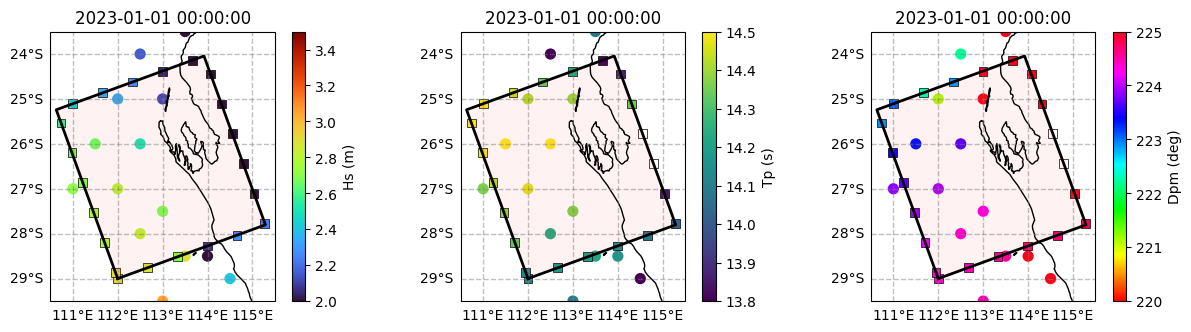

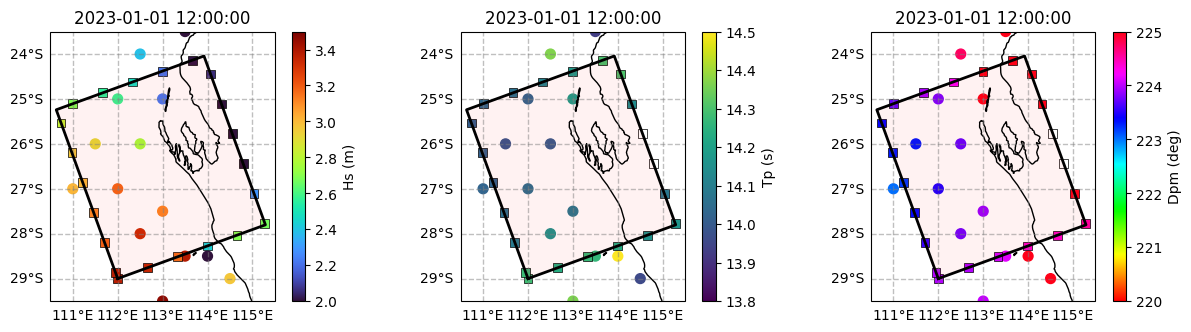

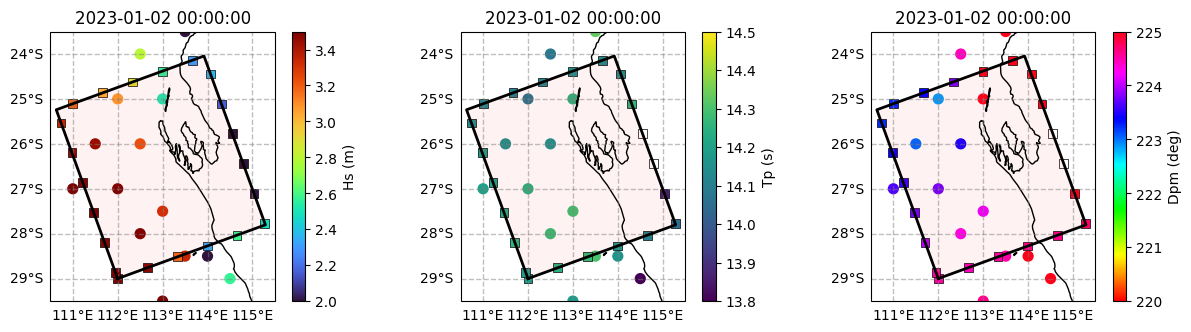

In [13]:
# Load the boundary created as a dataset
ds = wavespectra.read_swan(filename, as_site=True)
display(ds)

# Plot boundary stats calculated from ds
for time in ds.time.to_index()[::2]:
    plot_boundary_side(dset, ds, grid, time)

### Boundnest1 with custom spacing

Create `BOUNDNEST1` type SWAN boundary by interpolating from the source spectra
dataset along the model domain at locations along the grid boundary defined custom
`spacing` parameter.

<div class="alert alert-block alert-info">
⚠️ When using any custom spacing, it is possible there won't be boundary points defined
  at some of the grid vertices if the grid sides are not divisible by the spacing.
</div>

In [14]:
workspace = Path(mkdtemp(dir="model"))

bnd = Boundnest1(
    id="wa",
    source=source,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 2.0},
    rectangle="closed",
    spacing=1.0,
)

filename, cmd = bnd.get(destdir=workspace, grid=grid, time=times)

display(cmd)
os.system(f"head -n 80 {filename}");

"BOUNDNEST1 NEST 'wa.bnd' CLOSED"

SWAN   1                                Swan standard spectral file
$   Created by wavespectra
$   
TIME                                    time-dependent data
     1                                  time coding option
LONLAT                                  locations in spherical coordinates
    16                                  number of locations
  112.000000  -29.000000
  112.939693  -28.657980
  113.879385  -28.315960
  114.819078  -27.973940
  115.117914  -27.333083
  114.775894  -26.393391
  114.433874  -25.453698
  114.091854  -24.514005
  113.450997  -24.215169
  112.511305  -24.557189
  111.571612  -24.899209
  110.631919  -25.241230
  110.973940  -26.180922
  111.315960  -27.120615
  111.657980  -28.060307
  112.000000  -29.000000
AFREQ                                   absolute frequencies in Hz
    11                                  number of frequencies
    0.05417
    0.05959
    0.06555
    0.07210
    0.07931
    0.08724
    0.09597
    0.10557
    0.11612
    0.127

<xarray.Dataset> Size: 57kB
Dimensions:  (time: 5, site: 16, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 40B 2023-01-01 ... 2023-01-02
  * site     (site) int64 128B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * freq     (freq) float64 88B 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 64B 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, site, freq, dir) float64 56kB 0.0 0.0 0.0 ... 4.87e-05 0.0
    lat      (site) float64 128B -29.0 -28.66 -28.32 ... -27.12 -28.06 -29.0
    lon      (site) float64 128B 112.0 112.9 113.9 114.8 ... 111.3 111.7 112.0

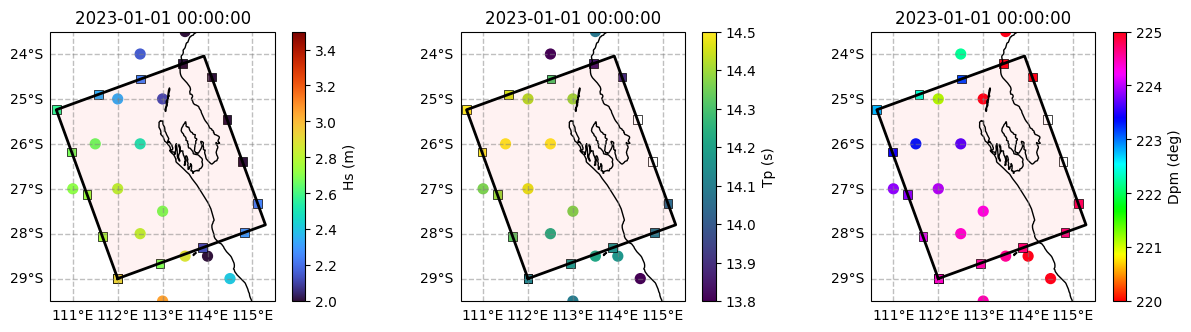

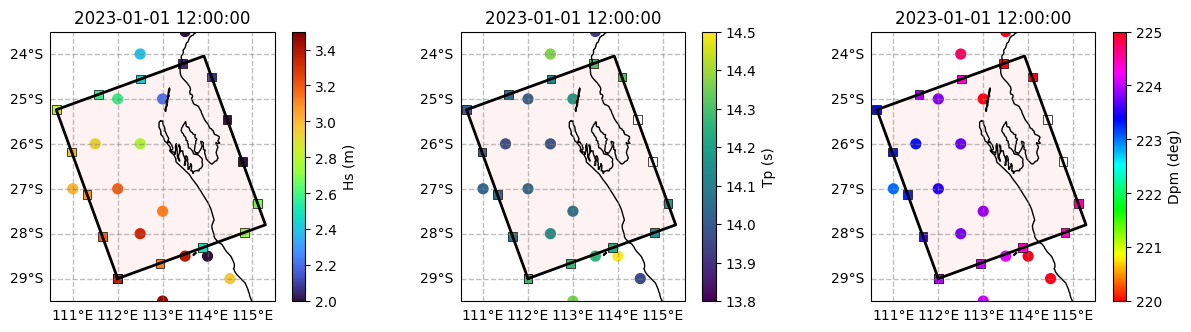

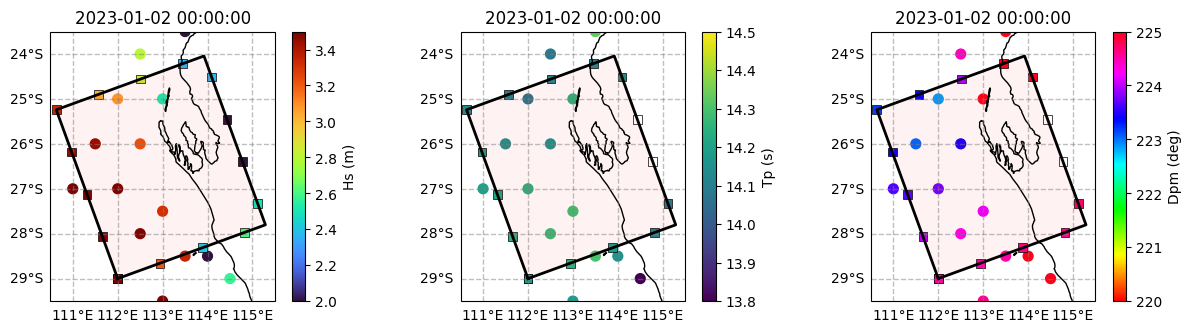

In [15]:
# Load the boundary created as a dataset
ds = wavespectra.read_swan(filename, as_site=True)
display(ds)

# Plot boundary stats calculated from ds
for time in ds.time.to_index()[::2]:
    plot_boundary_side(dset, ds, grid, time)